# 14.1 신경망 모델링 디자인

In [58]:
#1. 모델링 입력 파라미터 결정
import argparse
args = {
    # number of vocab : 단어사전의 크기
    "n_vocab": 32007,
    # number of input sequence : 입력 피처 수
    "n_seq": 67,
    # hidden size : 단어 벡터의 깊이, 통상 128, 256 등으로 지정
    "d_model": 128,
    # number of output
    "n_out": 2,
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)
args

Namespace(n_vocab=32007, n_seq=67, d_model=128, n_out=2, seed=1234)

# 14.2 데이터 준비 단계

In [59]:
#2 데이터 입력
import pandas as pd
df = pd.DataFrame()
df['review'] = [
    "신차 정말 좋아요",
    "신차 속도감 너무 안좋아",
    "신차 디자인 연비 좋아요",
    "신차 엉터리로 개발했네요",
    "디자인도 이쁘고 연비도 좋아서 비용절감 효과도 있어요",
    "최대출력 도달하는 시간이 많이 걸리네요"
]

# 출력 정답
id_to_labels = {0: "부정", 1: "긍정"}
df['labels'] = [1, 0, 1, 0, 1, 0]
df

,review,labels
0,신차 정말 좋아요,1
1,신차 속도감 너무 안좋아,0
2,신차 디자인 연비 좋아요,1
3,신차 엉터리로 개발했네요,0
4,디자인도 이쁘고 연비도 좋아서 비용절감 효과도 있어요,1
5,최대출력 도달하는 시간이 많이 걸리네요,0


In [60]:
# 3. 토큰화
words = []
for line in df['review']:
    for w in line.split():
        words.append(w)
words = list(dict.fromkeys(words))
words

['신차',
 '정말',
 '좋아요',
 '속도감',
 '너무',
 '안좋아',
 '디자인',
 '연비',
 '엉터리로',
 '개발했네요',
 '디자인도',
 '이쁘고',
 '연비도',
 '좋아서',
 '비용절감',
 '효과도',
 '있어요',
 '최대출력',
 '도달하는',
 '시간이',
 '많이',
 '걸리네요']

In [61]:
#4 단어사전 만들기와 n_vocab 사전크기 입력
vocab_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in vocab_id:
        vocab_id[w] = len(vocab_id)
vocab_word = {_id:w for w, _id in vocab_id.items()}
args.n_vocab = len(vocab_id)
vocab_word

{0: '[PAD]',
 1: '[UNK]',
 2: '신차',
 3: '정말',
 4: '좋아요',
 5: '속도감',
 6: '너무',
 7: '안좋아',
 8: '디자인',
 9: '연비',
 10: '엉터리로',
 11: '개발했네요',
 12: '디자인도',
 13: '이쁘고',
 14: '연비도',
 15: '좋아서',
 16: '비용절감',
 17: '효과도',
 18: '있어요',
 19: '최대출력',
 20: '도달하는',
 21: '시간이',
 22: '많이',
 23: '걸리네요'}

In [62]:
#5. 입력문장길이 n_seq 결정
args.n_seq = 6
args

Namespace(n_vocab=24, n_seq=6, d_model=128, n_out=2, seed=1234)

In [63]:
#6. 입력 텍스트를 n_seq 크기로 inputs을 만들고 labels 벡터 임베딩 준비
import numpy as np
from tqdm.notebook import tqdm, trange
def make_data(df, vocab=vocab_id, n_seq=args.n_seq):
    inputs, labels = [], []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["labels"]
        document = row["review"]
        token = []
        for word in document.split():
          token.append(vocab[word])
        token = token[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

inputs, labels = make_data(df, vocab_id, n_seq=args.n_seq)
inputs.shape, labels.shape

  0%|          | 0/6 [00:00<?, ?it/s]

((6, 6), (6,))

In [64]:
print(inputs)
print(labels)

[[ 2  3  4  0  0  0]
 [ 2  5  6  7  0  0]
 [ 2  8  9  4  0  0]
 [ 2 10 11  0  0  0]
 [12 13 14 15 16 17]
 [19 20 21 22 23  0]]
[1 0 1 0 1 0]


In [65]:
# 7. 데이터를 ts 크리의 test 데이터와 vs의 val 데이터로 분리
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.25, random_state=args.seed)
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(train_inputs, train_labels, test_size=1, random_state=args.seed)
train_inputs.shape, train_labels.shape

((3, 6), (3,))

In [66]:
print(train_inputs, train_labels)
print(valid_inputs, valid_labels)
print(test_inputs, test_labels)

[[ 2  3  4  0  0  0]
 [12 13 14 15 16 17]
 [ 2 10 11  0  0  0]] [1 1 0]
[[19 20 21 22 23  0]] [0]
[[2 8 9 4 0 0]
 [2 5 6 7 0 0]] [1 0]


# 14.3 신경망 모델링과 학습 단계

In [67]:
# 8. 단어벡터의 depth d_model을 결정
args.d_model = 5
args

Namespace(n_vocab=24, n_seq=6, d_model=5, n_out=2, seed=1234)

In [68]:
#9. 모델링 함수 정의 : bach_size
import tensorflow as tf
def build_model(args):
    """
    동작만 하는 간단한 모델
    :param args: input args
    """
    inputs = tf.keras.layers.Input((args.n_seq,))  # (bs, n_seq)
    # 가. 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    ########################################################
    # RNN, CNN, Attention, Dense ...
    ########################################################
    # 나. 문장의 특징 추출
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    # 다. 단어의 vector를 이용해서 정답 확률값 예측
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    outputs = linear(hidden)  # (bs, n_seq, n_out)
    # 라. 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

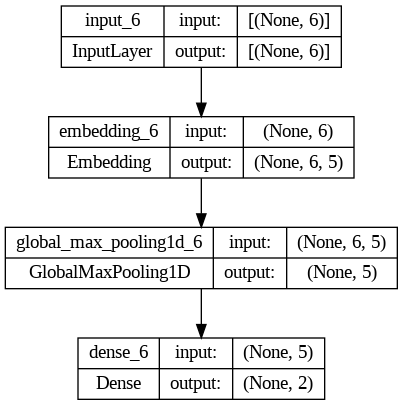

In [69]:
#10 모델을 생성하고 내용을 그래프로 출력, none 부분은 입력 데이터 수 즉, bach size 로 생각
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 모델링 이해*

In [70]:
# 모델링 파라미터 설정
args

Namespace(n_vocab=24, n_seq=6, d_model=5, n_out=2, seed=1234)

In [71]:
# 가. 입력 단어를 vector로 변환 bs * ( n_seq 4* n_vocab 12)*weight (n_vocab 12* d_model 5) = bs * n_seq 4* d_model 5
embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(3, 6, 5), dtype=float32, numpy=
array([[[-0.00891429, -0.04301273,  0.02168839,  0.00818386,
         -0.01681215],
        [ 0.04487835,  0.02647137,  0.04801742,  0.01912508,
         -0.0168865 ],
        [ 0.04100194, -0.04855696, -0.00693328, -0.02891024,
         -0.01730118],
        [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
         -0.04707748],
        [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
         -0.04707748],
        [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
         -0.04707748]],

       [[ 0.02640832, -0.02967944, -0.00753804, -0.03549138,
          0.01677639],
        [-0.02465688, -0.03964233, -0.02172563,  0.0163422 ,
         -0.01106175],
        [-0.01087167,  0.00263079,  0.03474705, -0.00929238,
          0.01288878],
        [ 0.03379072,  0.01335697,  0.03991855, -0.01472282,
         -0.00164224],
        [-0.0081709 ,  0.01114738,  0.04635109,  0.03447277,
         -0.02562171],
        [ 0.01328887,  

In [72]:
# embedding weight (12*5) : 단어별 벡터 첫번째 문장 [2,8,9,4]
weight = embedding.get_weights()[0]
weight

array([[ 0.04405488, -0.03111771,  0.01508827, -0.04198773, -0.04707748],
       [ 0.02524296,  0.03725063, -0.00057494, -0.03915143, -0.02287567],
       [-0.00891429, -0.04301273,  0.02168839,  0.00818386, -0.01681215],
       [ 0.04487835,  0.02647137,  0.04801742,  0.01912508, -0.0168865 ],
       [ 0.04100194, -0.04855696, -0.00693328, -0.02891024, -0.01730118],
       [ 0.01862575, -0.0292757 ,  0.02058249,  0.00602277,  0.00117651],
       [ 0.00895648,  0.0072757 , -0.0230533 , -0.00404932, -0.03121294],
       [ 0.04433144,  0.01989887, -0.01422862,  0.00392836, -0.02696441],
       [-0.01024093, -0.01962028,  0.04477629, -0.00608411,  0.03947497],
       [ 0.02587611,  0.01670067,  0.00980115,  0.0325444 , -0.04499207],
       [-0.03535476,  0.01523693, -0.01127139, -0.03997047,  0.01248879],
       [-0.03038385,  0.02231168,  0.013836  ,  0.03774827, -0.04998901],
       [ 0.02640832, -0.02967944, -0.00753804, -0.03549138,  0.01677639],
       [-0.02465688, -0.03964233, -0.0

In [73]:
# numpy를 이용해서 직접 조회 (두 결과값 비교), 2*4*5 bs*n_seq*d_model
weight[train_inputs], hidden

(array([[[-0.00891429, -0.04301273,  0.02168839,  0.00818386,
          -0.01681215],
         [ 0.04487835,  0.02647137,  0.04801742,  0.01912508,
          -0.0168865 ],
         [ 0.04100194, -0.04855696, -0.00693328, -0.02891024,
          -0.01730118],
         [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
          -0.04707748],
         [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
          -0.04707748],
         [ 0.04405488, -0.03111771,  0.01508827, -0.04198773,
          -0.04707748]],
 
        [[ 0.02640832, -0.02967944, -0.00753804, -0.03549138,
           0.01677639],
         [-0.02465688, -0.03964233, -0.02172563,  0.0163422 ,
          -0.01106175],
         [-0.01087167,  0.00263079,  0.03474705, -0.00929238,
           0.01288878],
         [ 0.03379072,  0.01335697,  0.03991855, -0.01472282,
          -0.00164224],
         [-0.0081709 ,  0.01114738,  0.04635109,  0.03447277,
          -0.02562171],
         [ 0.01328887,  0.02416846, -0.03828546,  0

In [74]:
# RNN, CNN, Attention, Linear ....

In [75]:
# 나. 문장의 특징 추출
tf.keras.layers.GlobalAvgPool1D()(hidden)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.03485511, -0.02640858,  0.01800623, -0.02126075, -0.03203871],
       [ 0.00496474, -0.00300303,  0.00891126,  0.00287215, -0.00153023],
       [ 0.00958529, -0.01646954,  0.0115863 , -0.02000025, -0.0325908 ]],
      dtype=float32)>

In [76]:
hidden = tf.keras.layers.GlobalMaxPooling1D()(hidden)
hidden

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.04487835,  0.02647137,  0.04801742,  0.01912508, -0.01681215],
       [ 0.03379072,  0.02416846,  0.04635109,  0.03447277,  0.01677639],
       [ 0.04405488,  0.02231168,  0.02168839,  0.03774827,  0.01248879]],
      dtype=float32)>

In [77]:
# 다. 단어의 vector를 이용해서 입력 배치 순서대로 n_out 크기로 부정(0), 긍정(1) 확률값 예측
linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
outputs = linear(hidden)
outputs

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.50007075, 0.49992925],
       [0.49521312, 0.50478697],
       [0.49151537, 0.5084846 ]], dtype=float32)>

In [78]:
# dense의 wieght, bias
weight, bias = linear.get_weights()
weight, bias

(array([[ 0.36083114,  0.1649034 ],
        [ 0.65982854,  0.7158545 ],
        [-0.06314325, -0.5341586 ],
        [-0.9031884 ,  0.5126374 ],
        [ 0.11523843, -0.03739035]], dtype=float32),
 array([0., 0.], dtype=float32))

In [79]:
# numpy를 이용한 Wx + b
logits = np.matmul(hidden, weight) + bias
logits

array([[ 0.01141714,  0.01113417],
       [-0.00398909,  0.01515923],
       [-0.00340583,  0.03053589]], dtype=float32)

In [80]:
# softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits)
denominator = np.sum(numerator, axis=1, keepdims=True)
numerator, denominator

(array([[1.0114826 , 1.0111965 ],
        [0.99601877, 1.0152746 ],
        [0.9966    , 1.0310069 ]], dtype=float32),
 array([[2.022679 ],
        [2.0112934],
        [2.027607 ]], dtype=float32))

In [81]:
# 두 결과값 비교
probs = numerator / denominator
probs, outputs

(array([[0.50007075, 0.49992928],
        [0.49521306, 0.50478697],
        [0.49151537, 0.5084846 ]], dtype=float32),
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0.50007075, 0.49992925],
        [0.49521312, 0.50478697],
        [0.49151537, 0.5084846 ]], dtype=float32)>)

In [82]:
#11 모델링과 학습
#가. 모델생성
model = build_model(args)
#나. 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#다. 조기종료 조건
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
#라. 모델 추론결과 weights 저장
save_weights = tf.keras.callbacks.ModelCheckpoint("sentence_calss.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
#마. 로그 저장
csv_logger = tf.keras.callbacks.CSVLogger("sentence_calss.csv")
#바. 모델 학습 시행 및 실행 결과 저장
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to sentence_calss.hdf5
1/1 [==============================] - 1s 851ms/step - loss: 0.6895 - accuracy: 1.0000 - val_loss: 0.6933 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 89ms/step - loss: 0.6885 - accuracy: 1.0000 - val_loss: 0.6942 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.6667
Epoch 3: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 55ms/step - loss: 0.6876 - accuracy: 0.6667 - val_loss: 0.6951 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.6667
Epoch 4: val_accuracy did not improve fr

# 14.4 평가 및 배포 단계

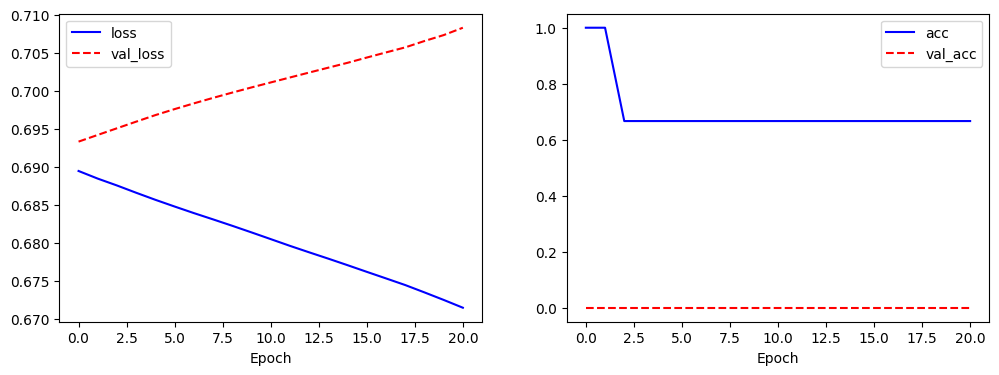

In [83]:
#12. 학습결과 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [84]:
#13. 모델 평가
model.load_weights("sentence_calss.hdf5")
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 27ms/step - loss: 0.6946 - accuracy: 0.5000


[0.6945995688438416, 0.5]

In [85]:
#14. 모델 배포 및 추론 함수 정의
model = build_model(args)
model.load_weights("sentence_calss.hdf5")

def do_predict(vocab_id, id_to_labels, model, string):
    n_seq = args.n_seq
    tokens = string.split()[:n_seq]
    # 입력을 숫자로 변경
    infer_input = [vocab_id.get(word, 1) for word in tokens]
    print(infer_input)
    # numpy array 변환
    infer_input += [0] * (n_seq - len(infer_input))
    infer_inputs = np.array([infer_input])
    print(infer_inputs)
    # 부정(0), 긍정(1) 추론
    y_preds = model.predict(infer_inputs)
    print(y_preds)
    # 확률의 max 값을 추론 값으로 결정
    y_pred_class = np.argmax(y_preds, axis=-1)[0]
    print(y_pred_class)
    # print(tokens)
    return id_to_labels[y_pred_class]

In [86]:
print(vocab_id)
print(id_to_labels)

{'[PAD]': 0, '[UNK]': 1, '신차': 2, '정말': 3, '좋아요': 4, '속도감': 5, '너무': 6, '안좋아': 7, '디자인': 8, '연비': 9, '엉터리로': 10, '개발했네요': 11, '디자인도': 12, '이쁘고': 13, '연비도': 14, '좋아서': 15, '비용절감': 16, '효과도': 17, '있어요': 18, '최대출력': 19, '도달하는': 20, '시간이': 21, '많이': 22, '걸리네요': 23}
{0: '부정', 1: '긍정'}


In [87]:
#15 새로운 데이터 입력  및 예측
string = '신차 정말 디자인 엉터리로'
do_predict(vocab_id, id_to_labels, model, string)

[2, 3, 8, 10]
[[ 2  3  8 10  0  0]]
1/1 [==============================] - 0s 61ms/step
[[0.50033665 0.49966335]]
0


'부정'

In [88]:
#16. 대화형으로 배포
# 예) 신차 연비 좋아요, 엉터리로 개발했네요 등
while True:
    print('input >> ', end='')
    string = input()
    string = string.strip()
    if not string:
        break
    result = do_predict(vocab_id, id_to_labels, model, string)
    print(result)

input >> 신차 연비 좋아요
[2, 9, 4]
[[2 9 4 0 0 0]]
1/1 [==============================] - 0s 21ms/step
[[0.49573037 0.50426966]]
1
긍정
input >> 엉터리로 개발했네요
[10, 11]
[[10 11  0  0  0  0]]
1/1 [==============================] - 0s 23ms/step
[[0.5001561  0.49984396]]
0
부정
input >> 
